In [61]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [62]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
from scipy.sparse import issparse

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw


from IPython.display import display
from os import path
import session_info
import logging

logging.basicConfig(level=logging.ERROR)


# Utility functions

In [63]:
def get_var_features_num(adata: AnnData, variable_features: int|float) -> int:
    detected_gene_nu = len(adata.var_names) 
    if variable_features <= 1:
        return int(detected_gene_nu * variable_features)
    else:
        return min(detected_gene_nu, variable_features)
    

def is_raw_counts(matrix) -> bool:
    if issparse(matrix):
        return matrix.count_nonzero() == matrix.astype("uint32").count_nonzero()
    else:
        return np.count_nonzero(matrix) == np.count_nonzero(matrix.astype("uint32"))
    

# Config

In [64]:
## Pipeline parameters

with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [65]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]
VARIABLE_FEATURES = config["normalization"]["VARIABLE_FEATURES"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_RANGE = config["clustering"]["CLUSTERING_RANGE"]

# Reading Files

In [66]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Normalize object

In [67]:
var_features = get_var_features_num(adata, VARIABLE_FEATURES)


if COUNTS_LAYER == "X":
    adata["counts"] = adata.X.copy()
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER]
else:
    raise ValueError("obj.X seems to be normalized and and the {COUNTS_LAYER} layer can't be found in the object")

if NORMALIZATION_METHOD == "log1p":
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X

    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
    # Similair to Seurat FindVariableFeatures(method='vst') 
    sc.pp.highly_variable_genes(adata, n_top_genes=var_features, batch_key=None, flavor="seurat_v3")

if NORMALIZATION_METHOD == "pearson_residuals":
    # Recipie for variable feature selection, pearson normalization, and PCA
    adata = sc.experimental.pp.recipe_pearson_residuals(adata=adata, n_top_genes = var_features)
    adata["p_residuals"] = adata.X.copy()


# Select Variable Features

number of variable genes is: 3660


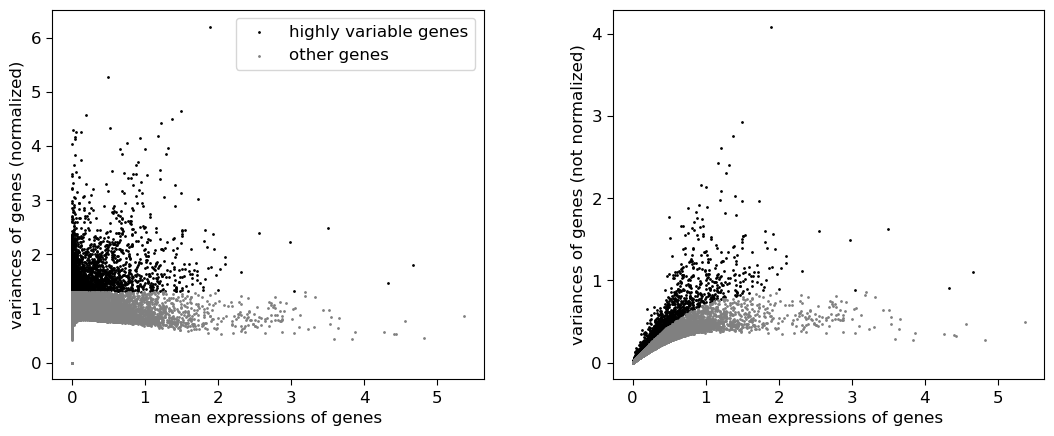

In [68]:
print(f"number of variable genes is: {var_features}")
sc.pl.highly_variable_genes(adata)

In [69]:
sc.pp.pca(adata)
sc.tl.umap(adata)

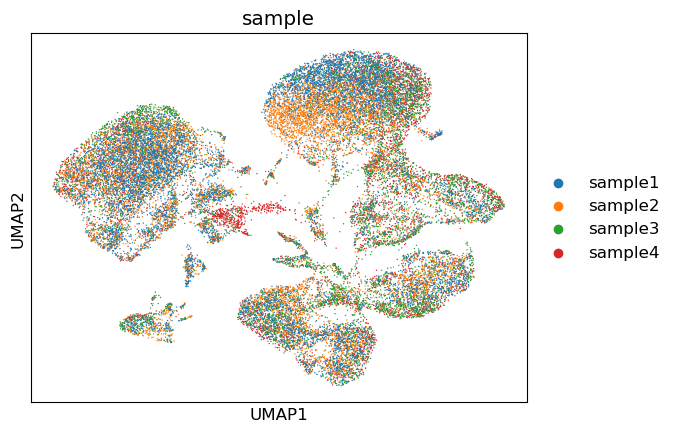

In [70]:
sc.pl.umap(adata, color="sample")

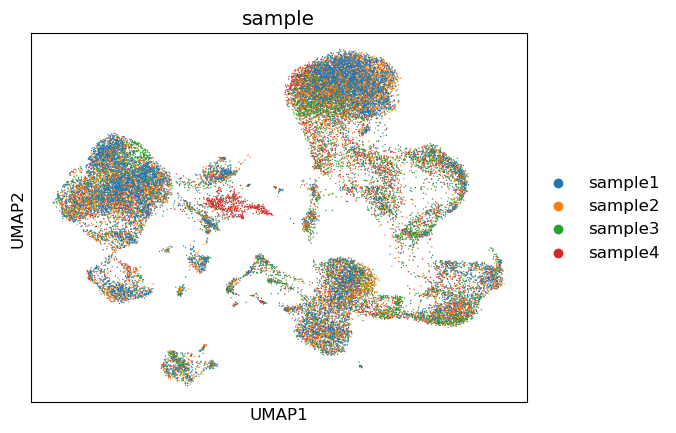

In [71]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [73]:
# sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
# sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
# sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

for i in np.arange(CLUSTERING_RANGE[0], CLUSTERING_RANGE[1], 0.3):
    resolution = np.around(i, decimals=3)
    sc.tl.leiden(adata=adata, key_added = f"leiden_{resolution*10}", resolution=resolution)

In [81]:
df = adata.obs.filter(regex= "leiden_")
df_renamed = df.rename(columns={col: col[:-4] for col in df.columns})
df_renamed

,leiden,leiden,leiden,leiden_,leiden_,leiden_,leiden_,leiden_,leiden_,leiden_
AAACCCAAGCCTGTCG-1,6,7,8,10,11,12,13,13,13,12
AAACCCACACAATGCT-1,2,2,3,2,2,2,1,1,0,14
AAACCCAGTTTACTGG-1,5,5,9,11,12,13,14,23,24,29
AAACCCATCATGAGGG-1,4,3,2,7,7,8,7,7,6,7
AAACCCATCTACACTT-1,0,0,0,1,1,0,9,12,9,11
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCATTGCA-1,2,2,5,8,6,6,6,6,4,3
TTTGTTGTCCTCTCGA-1,7,8,11,13,14,14,16,15,20,24
TTTGTTGTCGCACGAC-1,8,9,10,18,21,24,24,30,25,34
TTTGTTGTCGTCAACA-1,0,0,0,1,1,0,11,10,12,10


In [80]:
from clustree import clustree

clustree(df_renamed, prefix="leiden_", images="./")

ValueError: cols with prefix 'leiden_' should be consecutive integers:          'leiden_1', 'leiden_2', ..., 'leiden_N'